Практический проект по построению системы поиска аномалий.

Цель: В этом домашнем задании вам предстоит настроить систему по поиску аномалий в банковских транзакциях. Мало того, что аномальных значений в данных меньше одного процента, так еще и переменные анонимизированы и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых мы ничего не знаем). Смогут ли бравые unsupervised методы справится с такой задачей? Можно ли работать в таких условиях? Кто подставил кролика Роджера? 

Ответы на некоторые их этих вопросов вы узнаете после выполнения задания :)
1. Скачайте датасет с https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv и 

2. Проведите небольшой EDA (гистограммы и описательные статистики - обязательно)

3. Воспользуйтесь процентом аномалий, посчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета

4. Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров

5. Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и на сколько хорошо они это делают

6. При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек

Критерии оценки: Настроены и построены модели и методы, разобранные на занятии - 6 баллов

Посчитаны метрики и дана оценка качества работы алгоритмов - 2 балла

Визуализация работы алгоритмов при помощи tSNE/UMAP - 2 балла

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler

import warnings; warnings.filterwarnings(action='once')

%matplotlib inline


In [2]:
data = pd.read_csv('creditcard.csv')
data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# EDA

In [3]:
data.info();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
# Все признаки числовые и без пропусков.

In [5]:
data.iloc[:, :15].describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01


In [6]:
data.iloc[:, 15:].describe()


,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


В признаках видны выбросы: 75% процентиль и среднее отличаются в несколько раз от макимального значения по признаку, например для "Amount", "V28" и т.д.

In [7]:
data['Class'].value_counts()


0    284315
1       492
Name: Class, dtype: int64

In [8]:
data['Class'].value_counts(normalize = True)


0    0.998273
1    0.001727
Name: Class, dtype: float64

In [9]:
# выбросов у нас всего 0,17%

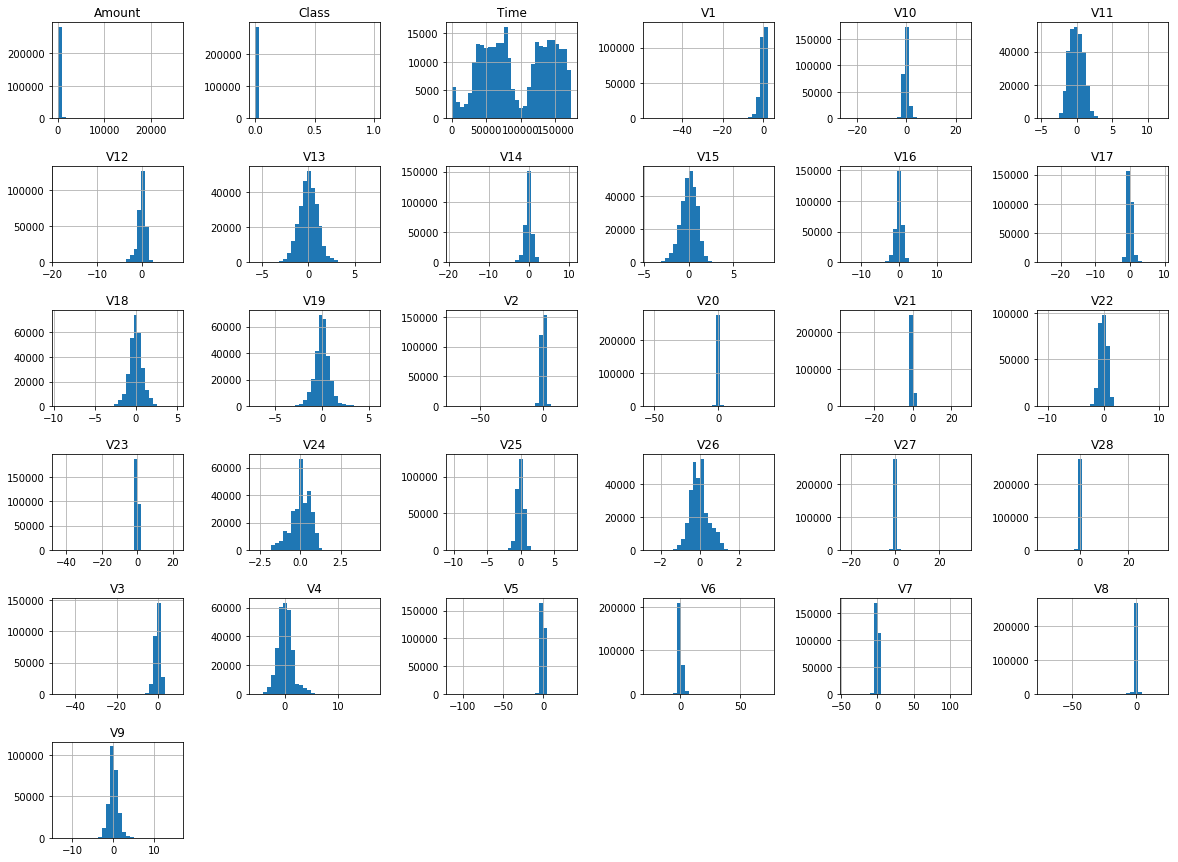

In [10]:
data.hist(bins = 30, figsize = (20, 15));
plt.subplots_adjust(wspace = 0.5, hspace = 0.5);


In [11]:
len(data.columns)


31

In [12]:
colum = data.columns.tolist()
colum.remove('Class')


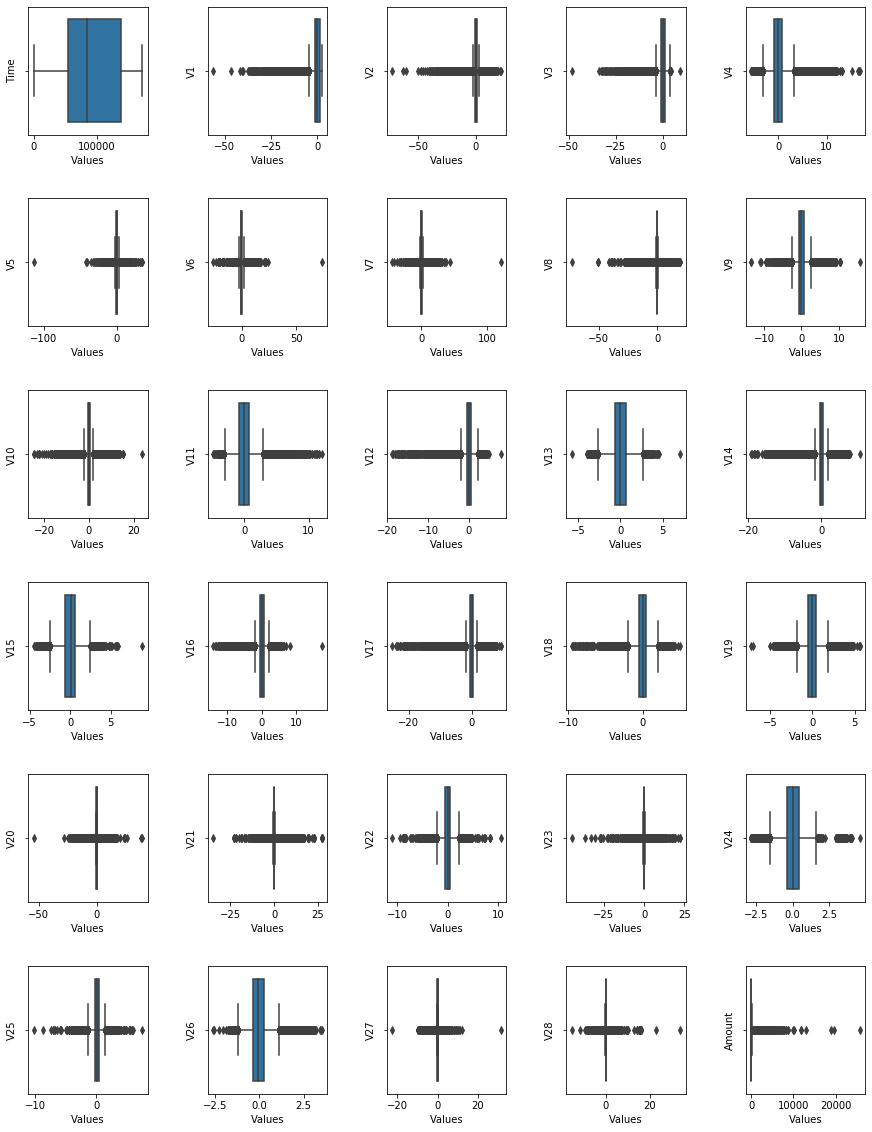

In [13]:
fig, axes = plt.subplots(nrows = 6, ncols = 5, figsize = (15, 20))

for idx, feat in enumerate(colum):
    sns.boxplot(data[feat], ax = axes[idx // 5, idx % 5])
    axes[idx // 5, idx % 5].set_xlabel('Values')
    axes[idx // 5, idx % 5].set_ylabel(feat);
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    

In [14]:
# на boxplot уже более явно видны отклонения

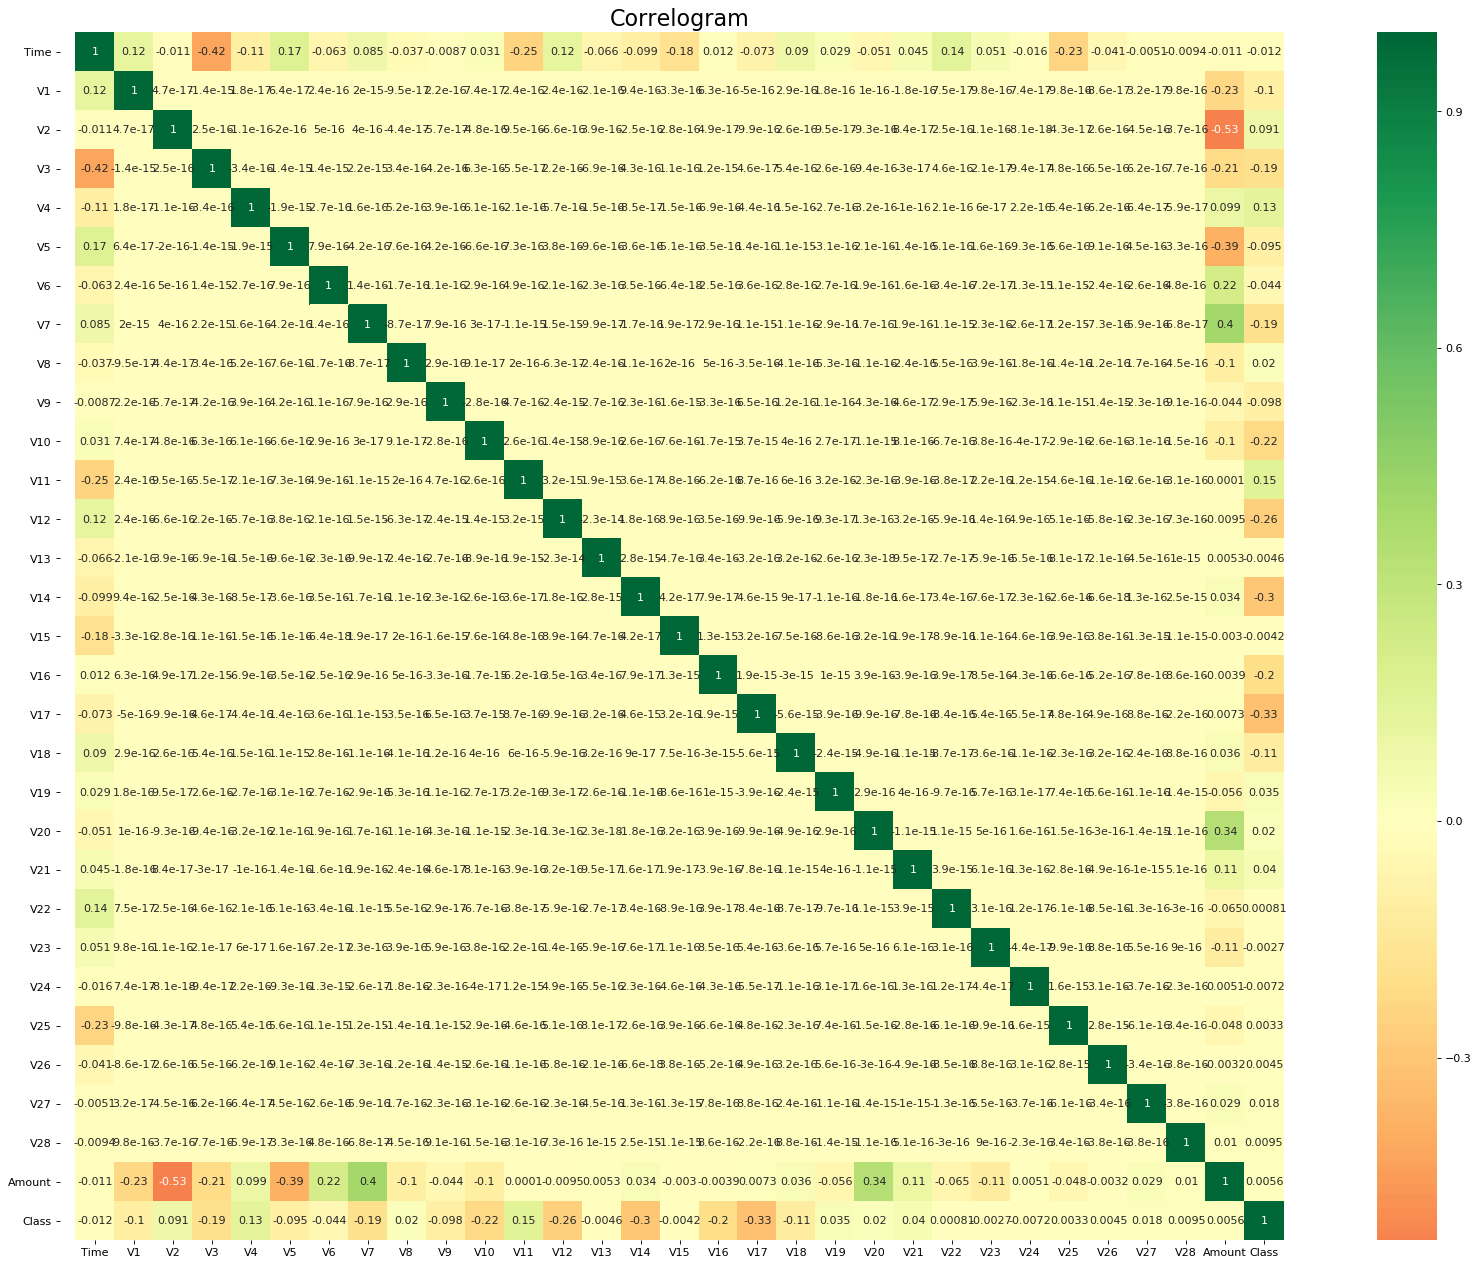

In [15]:
Corr = data.corr()

plt.figure(figsize = (25, 20), dpi = 80)
sns.heatmap(Corr, xticklabels = Corr.columns, yticklabels = Corr.columns, cmap = 'RdYlGn',
            center = 0, annot = True)

plt.title('Correlogram', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.axis('equal')
plt.show()


In [16]:
CorField = []
CorPairs = []
CorrDel = []

for i in Corr:
    for j in Corr.index[abs(Corr[i]) > 0.80]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            CorPairs.append([i, j, Corr[i][Corr.index == j].values[0]])
            CorrDel.append(i)
            print (i, '-->', j, ': R =', Corr[i][Corr.index == j].values[0])


In [17]:
# Признаков с сильной корреляцией не наблюдается


# ML

In [18]:
# Я уменьшил объем данных для ускорения обучения
data = data.sample(10000)
data['Class'].value_counts()


0    9991
1       9
Name: Class, dtype: int64

In [37]:
data['Class'].value_counts(normalize = True)

0    0.9991
1    0.0009
Name: Class, dtype: float64

CPU times: user 1min 48s, sys: 2.75 s, total: 1min 50s
Wall time: 1min 50s


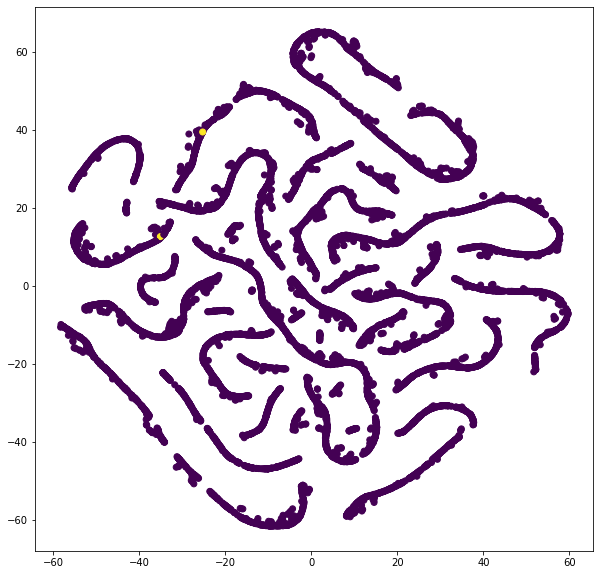

In [19]:
%%time

tsne = TSNE(n_jobs = -1)
tsne_transformed = tsne.fit_transform(data)
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = data['Class']);


In [20]:
# Интересные фигуры получаются на не отскалированных данных)

CPU times: user 1min 41s, sys: 1.8 s, total: 1min 43s
Wall time: 1min 42s


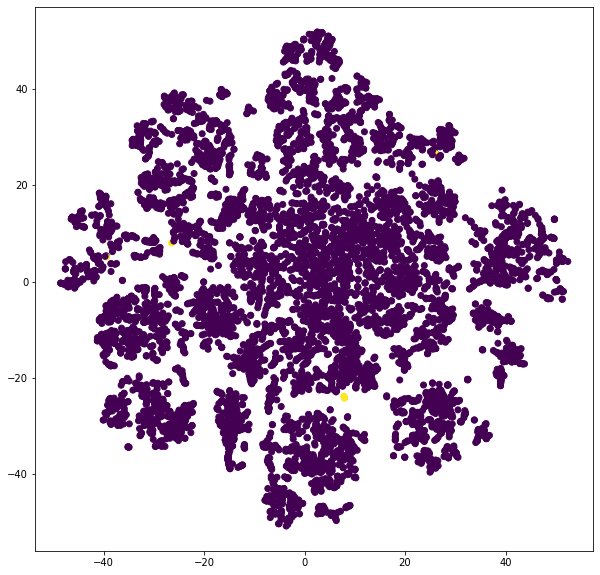

In [24]:
%%time

scaler = RobustScaler()
scaled_data = pd.DataFrame(data = scaler.fit_transform(data), columns = data.columns)

tsne = TSNE(n_jobs = -1)
tsne_transformed = tsne.fit_transform(scaled_data)
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = scaled_data['Class']);


In [25]:
percent_train = data['Class'].value_counts(normalize = True)[1] * 100


In [26]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [27]:
def print_result(std_outliers):

    y_pred = std_outliers.astype('int').tolist()
    y_true = data['Class'].tolist()
    print(classification_report(y_true, y_pred))
    
    font = {'size' : 14}
    plt.rc('font', **font)
    class_names = data['Class'].unique().tolist()
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
    plt.axis('equal')
    plt.savefig("conf_matrix.png")
    plt.show(); 
    

# 2. Простейшие методы

## <center> n-сигм</center> 

In [28]:
def outlier_std(data, col, threshold = 3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis = 1).any(1)
    return anomalies, up_bound, low_bound


In [29]:
def get_column_outliers(data, columns = None, function = outlier_std, threshold = 3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data = [False] * len(data), index  = data.index, name = 'is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold = threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 
                                    100 * sum(anomalies) / len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

def anomalies_report(outliers):
    return (100 * sum(outliers) / len(outliers))


In [56]:
percent_train = data['Class'].value_counts(normalize = True)[1] * 100
threshold = 1
thresholds = []
percentages = []

while True:
    comparison_table, std_outliers = get_column_outliers(data, columns = colum, threshold = threshold)
    thresholds.append(i)
    percentages.append(anomalies_report(std_outliers))
    if anomalies_report(std_outliers) <= percent_train:
        print ('best threshold:', i)
        best_threshold = i
        break
    threshold += 1
    

best threshold: 19


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.08      0.11      0.10         9

    accuracy                           1.00     10000
   macro avg       0.54      0.56      0.55     10000
weighted avg       1.00      1.00      1.00     10000



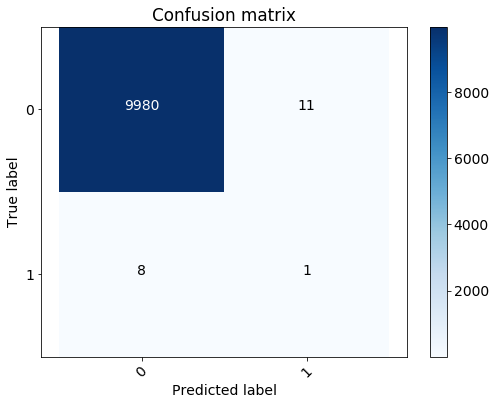

In [99]:
comparison_table, std_outliers = get_column_outliers(data, columns = colum, threshold = best_threshold)
std_outliers = std_outliers.astype('int')
print_result(std_outliers)


In [100]:
comparison_table


,upper_bound,lower_bound,anomalies_count,anomalies_percentage
Time,996102.943909,-805706.235309,0.0,0.00
V1,35.660511,-35.593550,0.0,0.00
V2,30.152059,-30.189735,0.0,0.00
V3,27.497588,-27.481165,0.0,0.00
V4,26.292973,-26.304268,0.0,0.00
V5,24.635146,-24.593695,0.0,0.00
V6,24.462800,-24.468829,0.0,0.00
V7,20.457549,-20.413096,0.0,0.00
V8,19.155919,-19.128219,1.0,0.01
V9,20.372917,-20.338987,0.0,0.00


CPU times: user 41.2 ms, sys: 2.08 ms, total: 43.3 ms
Wall time: 41.7 ms


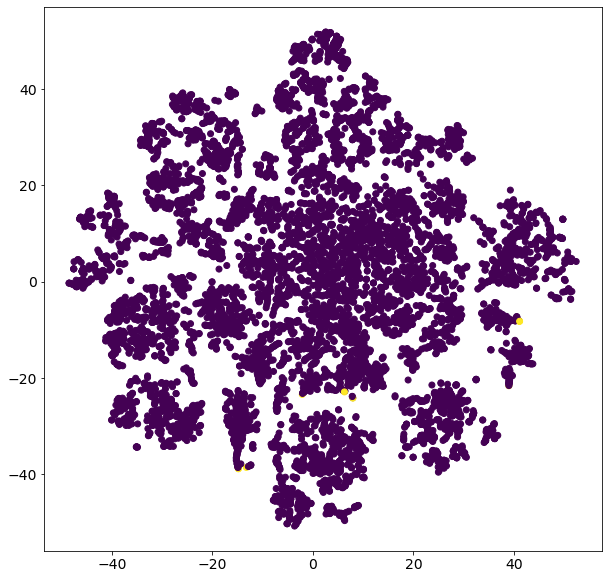

In [58]:
%%time
# Визуализируем:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = std_outliers);


In [89]:
# обнаружили лишь 1 из 9 выбросов, 8 объектов определены алгоритмом как выбросы не верно

## <center> Межквартильное отклонение</center> 


In [60]:
def outlier_iqr(data, col, threshold = 3):
    IQR = data[col].quantile(0.95) - data[col].quantile(0.05)
    up_bound = data[col].quantile(0.95) + (IQR * threshold)
    low_bound = data[col].quantile(0.05) - (IQR * threshold)
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis = 1).any(1)
    return anomalies, up_bound, low_bound


In [61]:
percent_train = data['Class'].value_counts(normalize = True)[1] * 100
threshold = 1
thresholds = []
percentages = []

while True:
    comparison_table, std_outliers = get_column_outliers(data, columns = colum, 
                                                         threshold = threshold, function = outlier_iqr)
    thresholds.append(i)
    percentages.append(anomalies_report(std_outliers))
    if anomalies_report(std_outliers) <= percent_train:
        print ('best threshold:', i)
        best_threshold = i
        break
    threshold += 1
    

best threshold: 19


In [54]:
thresholds = []
percentages = []

for i in range(3, 20):
    comparison_table, iqr_outliers = get_column_outliers(data, function = outlier_iqr, threshold = i)
    thresholds.append(i)
    percentages.append(anomalies_report(iqr_outliers))
    if anomalies_report(iqr_outliers) <= data['Class'].value_counts(normalize = True)[1] * 100:
        print ('best threshold:', i)
        best_threshold = i
        break
        

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.90      1.00      0.95         9

    accuracy                           1.00     10000
   macro avg       0.95      1.00      0.97     10000
weighted avg       1.00      1.00      1.00     10000



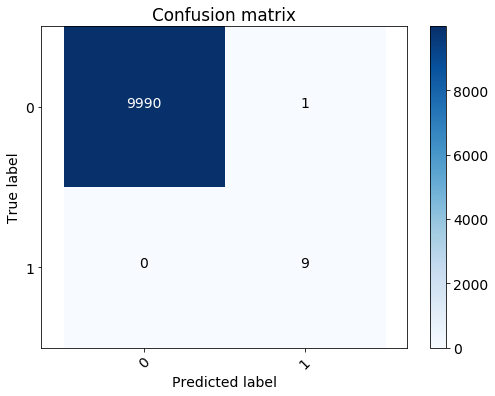

In [62]:
comparison_table, iqr_outliers = get_column_outliers(data, function = outlier_iqr, threshold = best_threshold)
print_result(iqr_outliers)


In [104]:
# А вот с помощью отсечения Межквартильным отклонением нашли все 9 выбросов, 
# но плюс 1 объект был определен как выброс не верно.

In [101]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
Time,996102.943909,-805706.235309,0.0,0.00
V1,35.660511,-35.593550,0.0,0.00
V2,30.152059,-30.189735,0.0,0.00
V3,27.497588,-27.481165,0.0,0.00
V4,26.292973,-26.304268,0.0,0.00
V5,24.635146,-24.593695,0.0,0.00
V6,24.462800,-24.468829,0.0,0.00
V7,20.457549,-20.413096,0.0,0.00
V8,19.155919,-19.128219,1.0,0.01
V9,20.372917,-20.338987,0.0,0.00


In [102]:
# Большего всего значений выбросов выявлено в признаках Amount, V21 и V20

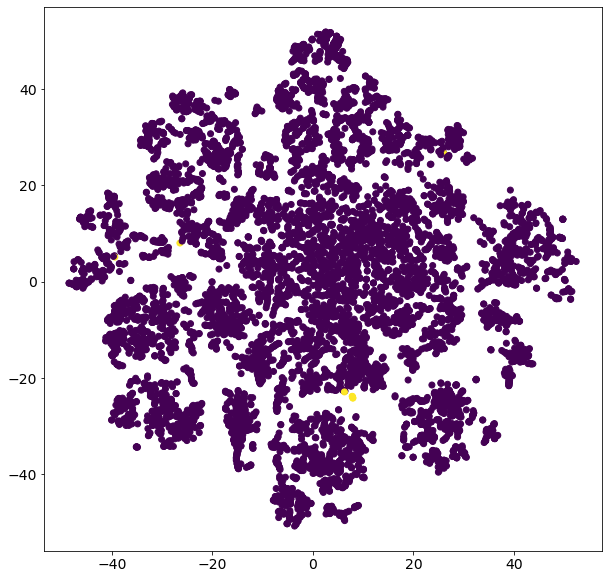

In [63]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = iqr_outliers);


# 3. Кластеризация

## <center> Distance-based</center> 

In [103]:
class DistanceOutliers(BaseEstimator):
    
    def __init__(self, metric = 'euclidean', percentile = 90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions
    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.00      0.00      0.00         9

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



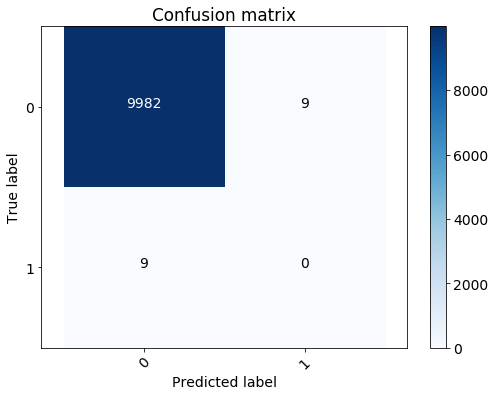

In [95]:
percent_train = data['Class'].value_counts(normalize = True)[1] * 100

euclidian_model = DistanceOutliers(metric='euclidean', percentile = 100 - percent_train)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)

print_result(euclidian_outliers)


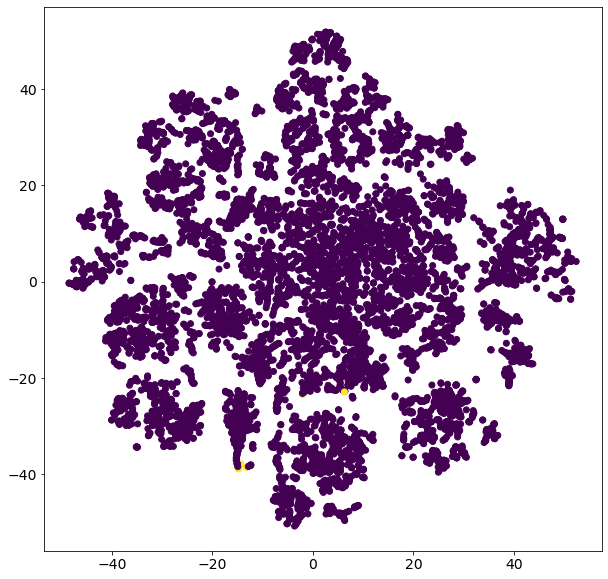

In [96]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = euclidian_outliers);


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.11      0.11      0.11         9

    accuracy                           1.00     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       1.00      1.00      1.00     10000



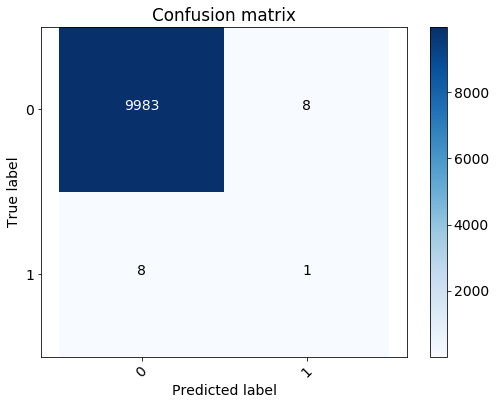

In [69]:
cityblock_model = DistanceOutliers(metric='cityblock', percentile = 100 - percent_train)
cityblock_model.fit(scaled_data)
cityblock_outliers = cityblock_model.predict(scaled_data)

print_result(cityblock_outliers)


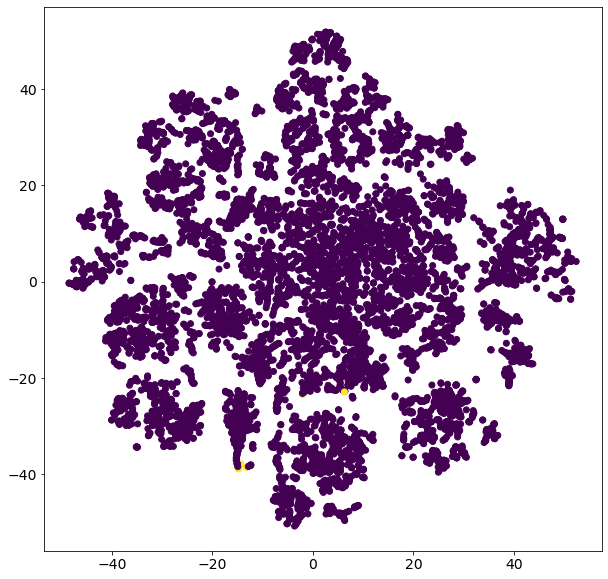

In [70]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = euclidian_outliers);


# 4. Density-based

## <center>DBSCAN</center>

In [73]:
%%time

outlier_percentage = 1
eps = 20

while outlier_percentage > 0.001:
    model = DBSCAN(eps = eps).fit(scaled_data)
    labels = model.labels_
    outlier_percentage = sum(labels == -1) / len(labels)
    print(eps, '| outlier_percentage: ', outlier_percentage)
    if outlier_percentage > 0.001:
        eps += 1
    else:
        break


20 | outlier_percentage:  0.0013
21 | outlier_percentage:  0.0013
22 | outlier_percentage:  0.0012
23 | outlier_percentage:  0.0009
CPU times: user 26.4 s, sys: 2.76 s, total: 29.2 s
Wall time: 27 s


In [74]:
model = DBSCAN(eps)
model.fit(scaled_data)
dbscan_outliers = np.array([1 if label == -1 else 0 for label in model.labels_])


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.00      0.00      0.00         9

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



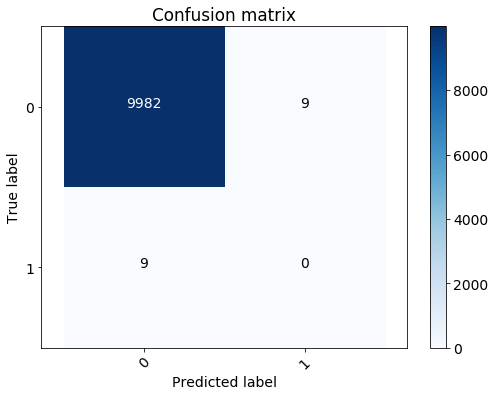

In [75]:
print_result(dbscan_outliers)


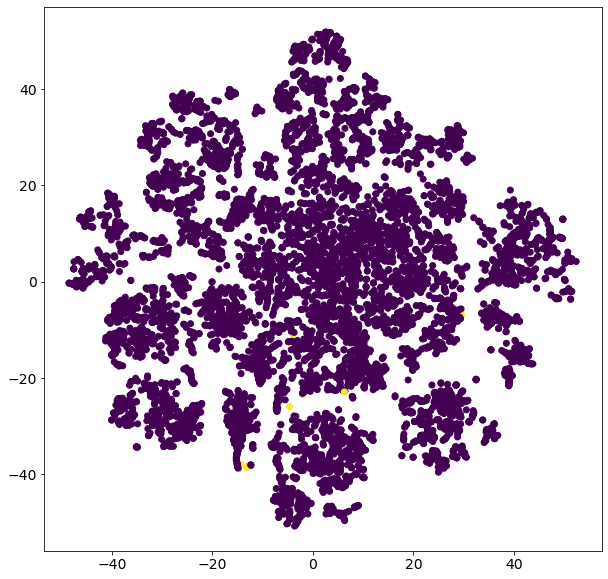

In [77]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = dbscan_outliers);


# 5. Unsupervised model-based

## <center>One-Class SVM</center>

In [78]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
        

In [80]:
%%time

nu_history = []
outlier_list = []

for i in frange(0.011, 0.013, 0.0001):
    
    one_class_svm = OneClassSVM(nu = i, gamma = 'auto')
    one_class_svm.fit(scaled_data)
    svm_outliers = one_class_svm.predict(scaled_data)
    outlier_percentage = sum(svm_outliers == -1) / len(svm_outliers)
    nu_history.append(i)
    outlier_list.append(outlier_percentage)

best_nu = nu_history[outlier_list.index(min(outlier_list))]
print(min(outlier_list) , best_nu)


0.029 0.012099999999999993
CPU times: user 15.8 s, sys: 400 ms, total: 16.2 s
Wall time: 16.2 s


In [81]:
# Самый лучший результат (т.е. минимальный процент выбросов в данных) получил равным 5,8%

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9991
           1       0.01      0.22      0.01         9

    accuracy                           0.97     10000
   macro avg       0.50      0.60      0.50     10000
weighted avg       1.00      0.97      0.98     10000



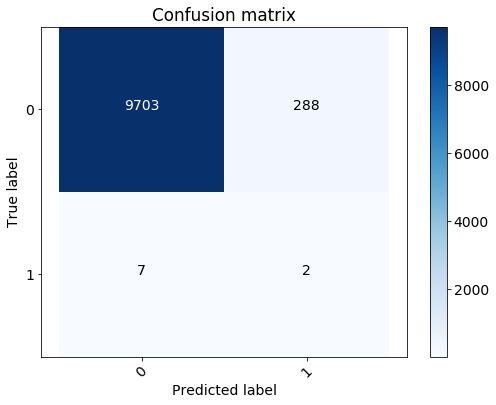

In [82]:
one_class_svm = OneClassSVM(nu = best_nu, gamma = 'auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

print_result(svm_outliers)


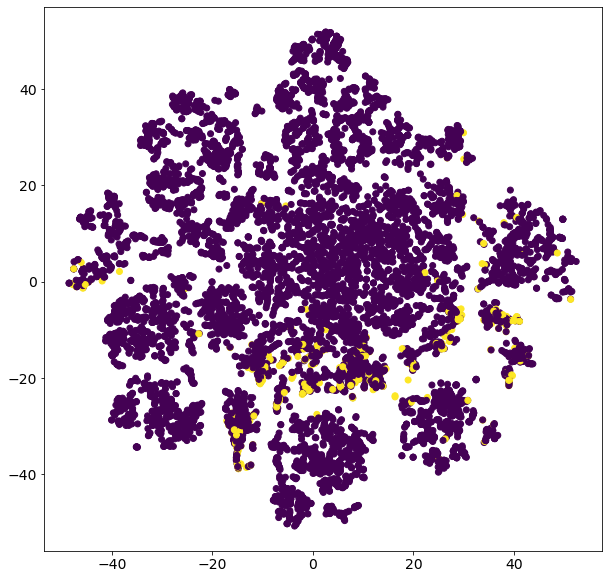

In [83]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = svm_outliers);


## <center>Isolation Forest</center>

/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9991
           1       0.00      0.00      0.00         9

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



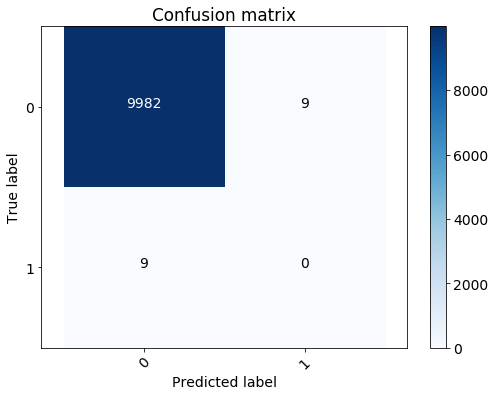

In [84]:
percent_train_for = data['Class'].value_counts(normalize = True)[1]

isolation_forest = IsolationForest(n_estimators = 100, contamination = percent_train_for, 
                                   max_features = 1.0, bootstrap = True, behaviour="new" , n_jobs = -1)
isolation_forest.fit(scaled_data)
isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])
print_result(isolation_outliers)


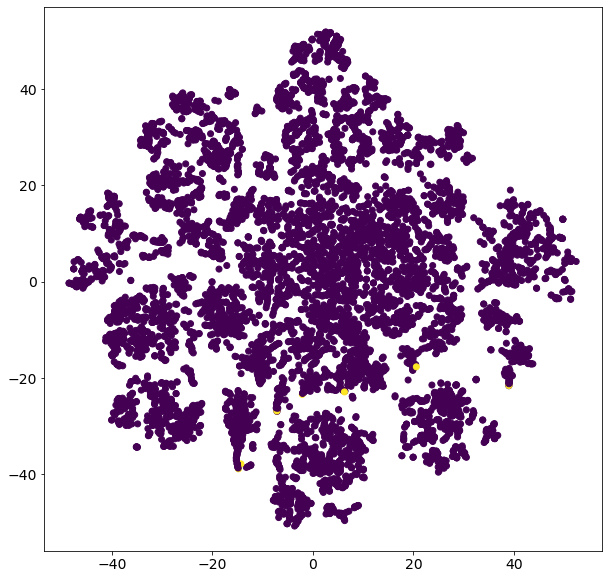

In [85]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c = isolation_outliers);


# Выводы

1. Для алгоритма OneClassSVM очень сложно подобрать параметры для подстройки под уже имеющие экспертные значения.
2. Для наших данных самым точным оказался подход с поиском межквартильных отклонений, причем значение квартиля было достаточно большим.
3. Isolation Forest, DBSCAN и расчет евклидова расстояния не нашли ни одного верного выброса.
4. Все остальные данные алгоритмы наш лишь 1, 2 объекта. Причем лишь те объекты, которые на графиках TSNE визуально неплохо отделимы.